## Importacion de Bibliotecas y Configuracion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import kagglehub
import pickle
from tensorflow.keras import models, layers, Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

2025-08-06 18:43:20.168649: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-06 18:43:20.179484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754527400.191514  110737 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754527400.195384  110737 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754527400.205156  110737 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
seed = 666
np.random.seed(seed)

## Funciones

In [3]:
def data_generator(batch_list, path_batches):
    for archivo in batch_list:
        with open(os.path.join(path_batches, archivo), 'rb') as f:
            data = pickle.load(f)
        X = data['X'].astype(np.float32)
        y_boxes = data['y_boxes'].astype(np.float32)

        if np.any(np.isnan(X)) or np.any(np.isnan(y_boxes)):
            print(f"⚠️ Batch {archivo} contiene NaNs. Saltando.")
            continue

        if np.max(y_boxes) > 1.0 or np.min(y_boxes) < 0.0:
            print(f"⚠️ Batch {archivo} tiene cajas fuera de [0,1]. Saltando.")
            continue

        yield X, y_boxes

## Carga de Dataset

In [4]:
path = kagglehub.dataset_download("alincijov/self-driving-cars")

print("Path to dataset files:", path)

Path to dataset files: /home/paul-h-roldan-hernandez/.cache/kagglehub/datasets/alincijov/self-driving-cars/versions/4


In [5]:
csv_path = os.path.join(path, 'labels_trainval.csv')
df = pd.read_csv(csv_path)
img_path = os.path.join(path, 'images')

## Exploracion de datos

In [6]:
df['class_id'].value_counts()

class_id
1    123314
5     17253
3     15540
2      7322
4      1676
Name: count, dtype: int64

In [7]:
df['class_id'].value_counts()/len(df)

class_id
1    0.746882
5    0.104497
3    0.094122
2    0.044348
4    0.010151
Name: count, dtype: float64

In [8]:
df.isnull().sum()

frame       0
xmin        0
xmax        0
ymin        0
ymax        0
class_id    0
dtype: int64

In [9]:
df[df['class_id'] == 3].head(20)

,frame,xmin,xmax,ymin,ymax,class_id
1,1478019952686311006.jpg,437,454,120,186,3
63,1478019961680640592.jpg,264,271,139,155,3
69,1478019962181150666.jpg,268,275,138,156,3
76,1478019962681840550.jpg,271,280,137,156,3
82,1478019963181283434.jpg,278,287,138,158,3
88,1478019963682173845.jpg,285,295,138,160,3
93,1478019964181479375.jpg,295,306,133,155,3
96,1478019964687995430.jpg,306,319,137,160,3
102,1478019965181415731.jpg,328,342,132,164,3
107,1478019965682301515.jpg,350,367,127,168,3


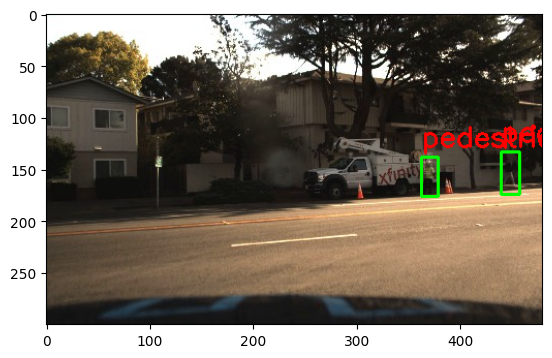

In [10]:
clases = {
    1: 'car',
    2: 'truck',
    3: 'pedestrian',
    4: 'bicyclist',
    5: 'light'
}

aux = '1478019982681185768.jpg'
path_img = os.path.join(img_path, aux)
img_vis = cv2.imread(path_img)
img_rgb = cv2.cvtColor(img_vis,cv2.COLOR_BGR2RGB)
df_aux = df[(df['frame'] == aux) & (df['class_id'] == 3)]
for _, row in df_aux.iterrows():
    x1, y1 = int(row['xmin']), int(row['ymin'])
    x2, y2 = int(row['xmax']), int(row['ymax'])
    class_id = int(row['class_id'])
    label = clases.get(class_id, 'unknown')
    
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0,255,0), 2)
    
    cv2.putText(img_rgb, label,(x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
plt.imshow(img_rgb)
plt.show()

## Procesamiento de datos

In [11]:
df['class_id'].value_counts()

class_id
1    123314
5     17253
3     15540
2      7322
4      1676
Name: count, dtype: int64

In [12]:
df_filtrado = df[df['class_id'] == 3].copy()

In [13]:
df_filtrado 

,frame,xmin,xmax,ymin,ymax,class_id
1,1478019952686311006.jpg,437,454,120,186,3
63,1478019961680640592.jpg,264,271,139,155,3
69,1478019962181150666.jpg,268,275,138,156,3
76,1478019962681840550.jpg,271,280,137,156,3
82,1478019963181283434.jpg,278,287,138,158,3
...,...,...,...,...,...,...
164990,1479506168470775690.jpg,232,243,140,163,3
165001,1479506168990704654.jpg,225,241,133,154,3
165013,1479506169996887187.jpg,263,282,127,161,3
165025,1479506170991708816.jpg,344,375,105,168,3


In [73]:
IMG_SIZE = 224
batch = 1_000

df_filtrado = df_filtrado.sample(frac=1, random_state=seed).reset_index(drop=True)

for start_idx in range(0, len(df_filtrado), batch):
    end_idx = min(start_idx + batch, len(df_filtrado))
    batch_df = df_filtrado.iloc[start_idx:end_idx]
    print(f"Procesando lote {start_idx // batch + 1}: {start_idx}-{end_idx}")
    X_batch, y_boxes_batch = [], []
    for (_, row) in batch_df.iterrows():
        img = cv2.imread(os.path.join(img_path, row['frame']))
        if img is None:
            continue

        original_height, original_width = img.shape[:2]

        x_min = row['xmin'] / original_width
        x_max = row['xmax'] / original_width
        y_min = row['ymin'] / original_height
        y_max = row['ymax'] / original_height
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

        X_batch.append(img)
        y_boxes_batch.append([x_min, y_min, x_max, y_max])

    batch_data = {
        'X': np.array(X_batch),
        'y_boxes': np.array(y_boxes_batch)
    }
    batch_filename = os.path.join('Frames_Procesadas_M4', f"batch_{start_idx // batch}.pkl")
    with open(batch_filename, 'wb') as f:
        pickle.dump(batch_data, f)
    file_size_mb = os.path.getsize(batch_filename) / (1024 * 1024)
    print(f"Lote completado: {len(X_batch)} imágenes - {file_size_mb:.1f} MB")
    del X_batch, y_boxes_batch



Procesando lote 1: 0-1000
Lote completado: 1000 imágenes - 1148.5 MB
Procesando lote 2: 1000-2000
Lote completado: 1000 imágenes - 1148.5 MB
Procesando lote 3: 2000-3000
Lote completado: 1000 imágenes - 1148.5 MB
Procesando lote 4: 3000-4000
Lote completado: 1000 imágenes - 1148.5 MB
Procesando lote 5: 4000-5000
Lote completado: 1000 imágenes - 1148.5 MB
Procesando lote 6: 5000-6000
Lote completado: 1000 imágenes - 1148.5 MB
Procesando lote 7: 6000-7000
Lote completado: 1000 imágenes - 1148.5 MB
Procesando lote 8: 7000-8000
Lote completado: 1000 imágenes - 1148.5 MB
Procesando lote 9: 8000-9000
Lote completado: 1000 imágenes - 1148.5 MB
Procesando lote 10: 9000-10000
Lote completado: 1000 imágenes - 1148.5 MB
Procesando lote 11: 10000-11000
Lote completado: 1000 imágenes - 1148.5 MB
Procesando lote 12: 11000-12000
Lote completado: 1000 imágenes - 1148.5 MB
Procesando lote 13: 12000-13000
Lote completado: 1000 imágenes - 1148.5 MB
Procesando lote 14: 13000-14000
Lote completado: 1000 im

Se transforman las imagenes y se guardan con pickle debido a la alta demanda de memoria y despues se cargan esos archivo snuevamente

## Modelo

In [14]:
path_batches = 'Frames_Procesadas_M4'
all_batches = sorted([f for f in os.listdir(path_batches) if f.lower().endswith('.pkl')])
np.random.shuffle(all_batches)
num_val = int(0.2*len(all_batches))
test_batches = all_batches[:num_val]
train_batches = all_batches[num_val:]

In [15]:
print(f"Train batches: {len(train_batches)}")
print(f"Validation batches: {len(test_batches)}")

Train batches: 13
Validation batches: 3


In [23]:
IMG_SIZE = 224


inp = Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = layers.Conv2D(32,(5,5),activation='relu',padding='same')(inp)
x = layers.MaxPool2D(pool_size=(2,2))(x)
x = layers.Conv2D(64,(5,5),activation='relu',padding='same')(x)
x = layers.MaxPool2D(pool_size=(2,2))(x)
x = layers.Conv2D(128,(5,5),activation='relu',padding='same')(x)
x = layers.MaxPool2D(pool_size=(2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
out_box = layers.Dense(4,activation='sigmoid', name = 'box_output')(x)


In [24]:
model_cnn = Model(inputs = inp, outputs = out_box)

In [25]:
model_cnn.compile(
    optimizer='adam', 
    loss ='mae',
    metrics = ['mean_absolute_error']
)

In [26]:
model_cnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │     3,211,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ box_output (Dense)              │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,470,052 (13.24 MB)

 Trainable params: 3,470,052 (13.24 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
early_stop = EarlyStopping(monitor='mean_absolute_error', patience=25, restore_best_weights=True,mode = 'max')
check = ModelCheckpoint('Models/Model_CNN_Object_Detection.keras', save_best_only=True, 
                        save_weights_only=False,monitor='mean_absolute_error',mode = 'max')

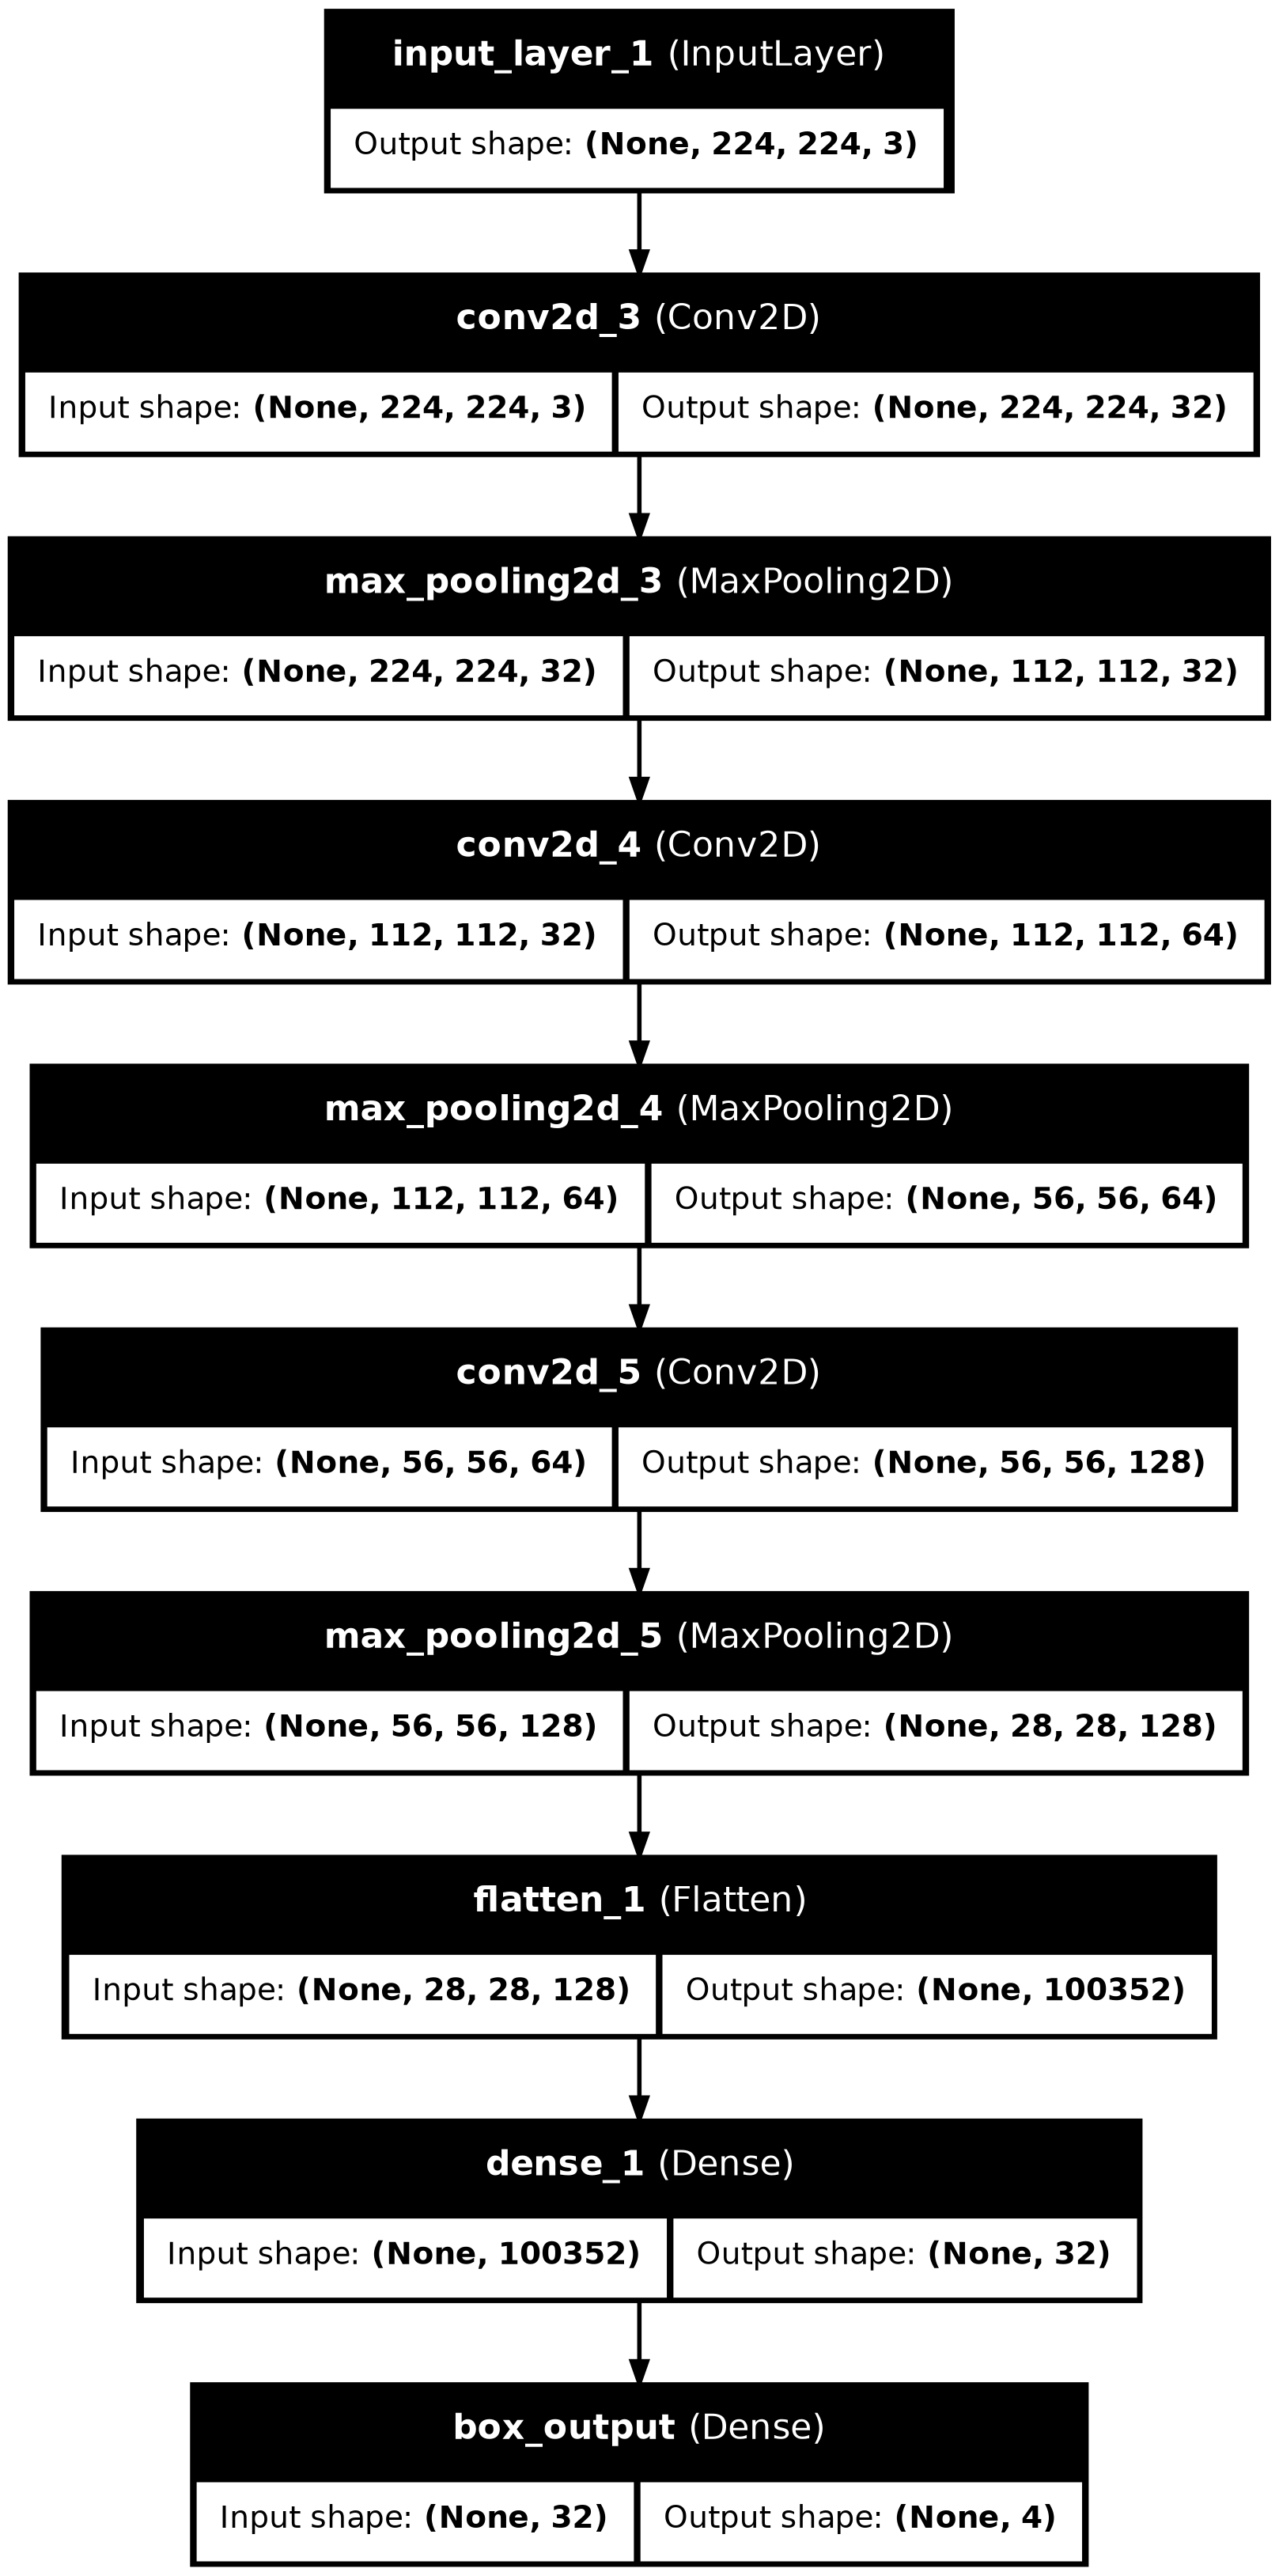

In [28]:
plot_model(model_cnn, show_shapes=True, show_layer_names=True)

In [29]:
EPOCHS = 30

for epoch in range(EPOCHS):
    print(f"\n🔁 Epoch {epoch+1}/{EPOCHS}")
    train_gen = data_generator(train_batches, path_batches)
    for i, (X_batch, y_batch) in enumerate(train_gen):
        model_cnn.fit(
            X_batch, y_batch,
            batch_size=16,
            epochs=1,
            verbose=1,
            callbacks=[early_stop, check]
        )

    val_gen = data_generator(test_batches, path_batches)
    val_losses = []
    for X_val, y_val in val_gen:
        val_loss = model_cnn.evaluate(X_val, y_val, verbose=0)
        val_losses.append(val_loss)

    mean_val_loss = np.mean(val_losses, axis=0)
    print(f"\n📊 Validación - Loss promedio: {mean_val_loss}")




🔁 Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.1568 - mean_absolute_error: 0.1568
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1316 - mean_absolute_error: 0.1316
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1310 - mean_absolute_error: 0.1310
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1357 - mean_absolute_error: 0.1357
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.1421 - mean_absolute_error: 0.1421
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1290 - mean_absolute_error: 0.1290
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1230 - mean_absolute_error: 0.1230
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1172 - mean_absolute_error: 0.1172
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1283 - mean_absolute_error: 0.1283
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1174 - mean_absolute_error: 0.1174
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1234 - mean_absolute_error: 0.1234
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.

## Validacion

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


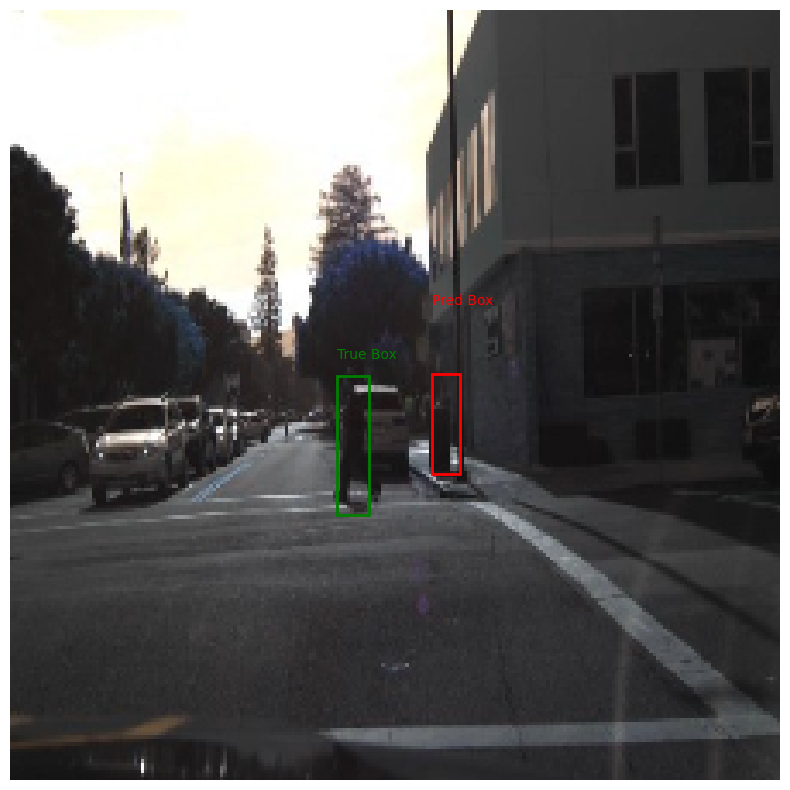

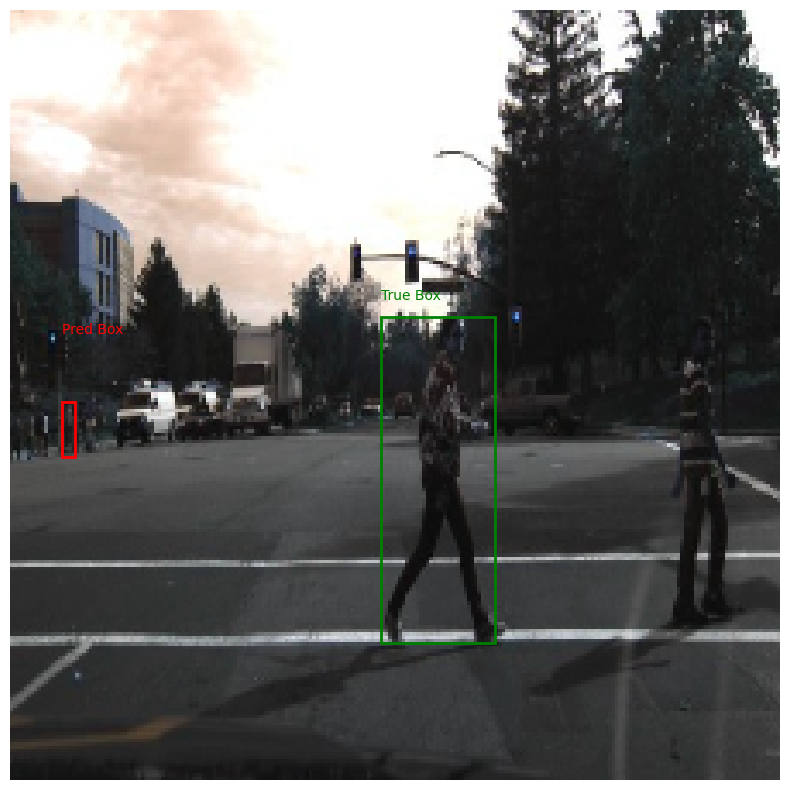

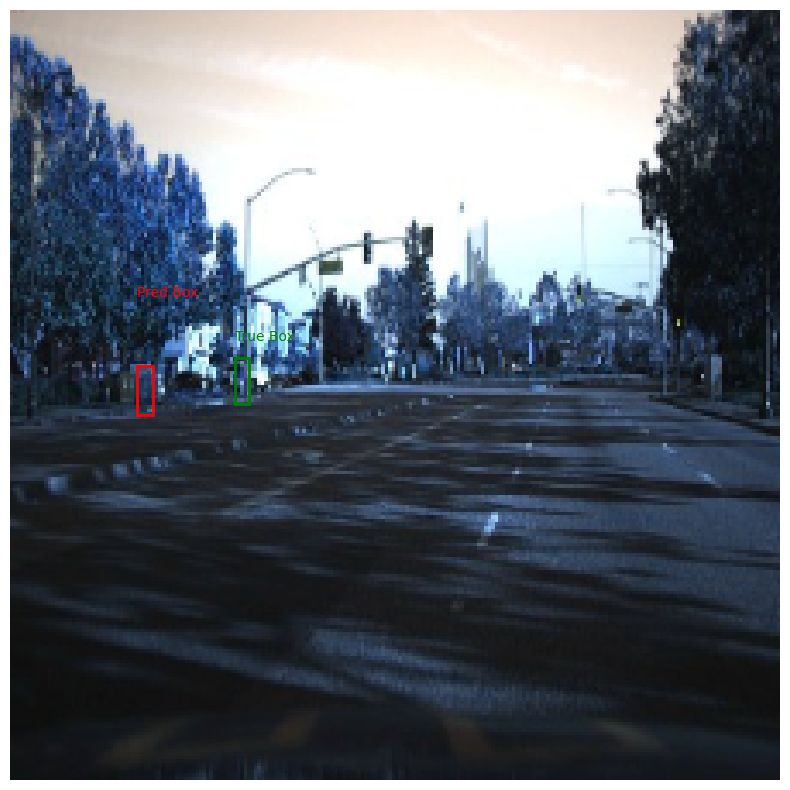

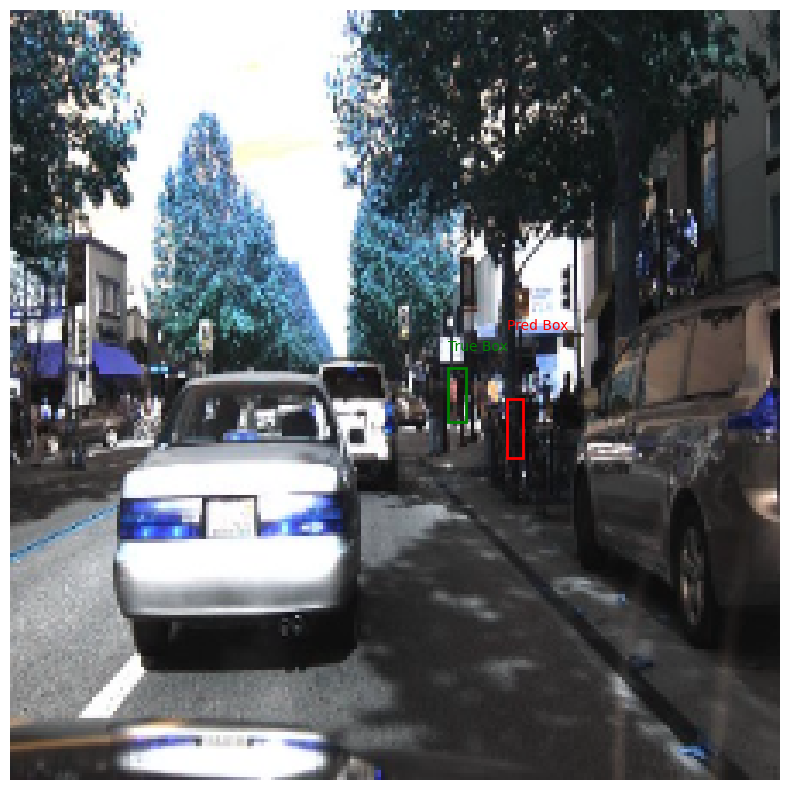

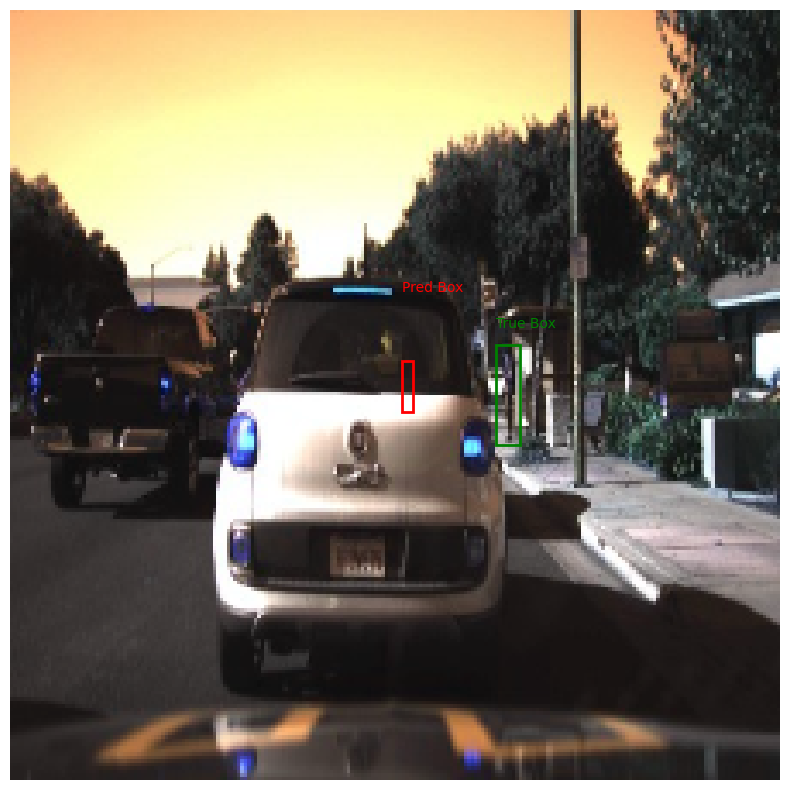

In [30]:

val_gen = data_generator(test_batches, path_batches)
X_val, y_val = next(val_gen)

# Obtener predicciones (solo cajas)
y_pred_boxes = model_cnn.predict(X_val)

# Visualizar las primeras 5 imágenes con cajas reales y predichas
for i in range(5):
    img = X_val[i]
    true_box = y_val[i]
    pred_box = y_pred_boxes[i]

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()

    # Caja real (verde)
    x1, y1, x2, y2 = true_box
    ax.add_patch(plt.Rectangle((x1*IMG_SIZE, y1*IMG_SIZE),
                               (x2 - x1)*IMG_SIZE, (y2 - y1)*IMG_SIZE,
                               edgecolor='green', facecolor='none', linewidth=2))
    plt.text(x1*IMG_SIZE, y1*IMG_SIZE - 5, f"True Box", color='green')

    # Caja predicha (rojo)
    x1p, y1p, x2p, y2p = pred_box
    ax.add_patch(plt.Rectangle((x1p*IMG_SIZE, y1p*IMG_SIZE),
                               (x2p - x1p)*IMG_SIZE, (y2p - y1p)*IMG_SIZE,
                               edgecolor='red', facecolor='none', linewidth=2))
    plt.text(x1p*IMG_SIZE, y1p*IMG_SIZE - 20, f"Pred Box", color='red')

    plt.axis('off')
    plt.show()



Como se puede ver en la muetsra de imagenes las predicciones no estan del todo mal, de 5 imagenes detecto correctamente la clase en 4 y no fue demasiado lejana la caja con respecto  a la prediccion, aunque en ninguna predijo correctamente.

In [31]:
ious = []

val_gen = data_generator(test_batches, path_batches)
for X_val, y_val in val_gen:
    y_pred_boxes = model_cnn.predict(X_val, verbose=0)

    for i in range(len(X_val)):
        true_box = y_val[i]
        pred_box = y_pred_boxes[i]

        # Validar cajas (por si acaso)
        if true_box[2] < true_box[0] or true_box[3] < true_box[1]:
            #print("Caja real inválida:", true_box)
            continue
        if pred_box[2] < pred_box[0] or pred_box[3] < pred_box[1]:
            #print("Caja predicha inválida:", pred_box)
            continue

        # Calcular intersección
        x1 = max(true_box[0], pred_box[0])
        y1 = max(true_box[1], pred_box[1])
        x2 = min(true_box[2], pred_box[2])
        y2 = min(true_box[3], pred_box[3])

        inter_area = max(0, x2 - x1) * max(0, y2 - y1)

        # Áreas individuales
        box1_area = (true_box[2] - true_box[0]) * (true_box[3] - true_box[1])
        box2_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])

        union_area = box1_area + box2_area - inter_area
        iou = inter_area / union_area if union_area != 0 else 0

        ious.append(iou)

mean_iou = np.mean(ious)
print(f"📦 IoU promedio: {mean_iou:.4f}")

📦 IoU promedio: 0.0398
